<a href="https://colab.research.google.com/github/Sabaudian/AMD_Market_Basket_Analysis/blob/main/AMD_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithm for Massive Datasets Project

## Project 2: Market-basket analysis

The task is to implement from scratch a system finding frequent itemsets (aka market-basket analysis), considering each movie as a basket and the actors as items.


### Import

In [1]:
# Installing libraries
!pip install -q ipython-autotime

%load_ext autotime

time: 354 µs (started: 2024-09-03 13:19:47 +00:00)


In [33]:
# Import
import os
import csv
import time
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from itertools import combinations
from collections import defaultdict, Counter

import warnings
warnings.filterwarnings("ignore")


time: 1.28 ms (started: 2024-09-03 13:43:40 +00:00)


In [3]:
# Constants

# PATHS
DATA_PATH = "/content/dataset"                                # Path to dataset folder
ACTORS_ZIP_PATH = os.path.join(DATA_PATH, "actors.csv.zip")   # Path to zip file
ACTORS_CSV_PATH = os.path.join(DATA_PATH, "actors.csv")       # Path to csv file

# ALGORITHM RELATED
DATA_FRACTION = 0.1                                # Data fraction to be sampled
SUPPORT_THRESHOLD = 10                             # Support threshold
BUCKET_NUMBER = 50123                              # Number of buckets
CONFIDENCE_THRESHOLD = 0.75                        # Confidence threshold
APRIORI = "A-PRIORI"                               # A-priori string name
PCY = "PCY"                                        # PCY string name
SAMPLE_LIST = [100000, 200000, 300000, 600000]     # Sample list


time: 2.86 ms (started: 2024-09-03 13:19:48 +00:00)


### Set-up Kaggle API and Download the dataset

#### Download Kaggle API Credentials:
1. Go to your [Kaggle account](https://www.kaggle.com/).
2. In the "API" section, click on "Create new API Token".
3. This will download a **kaggle.json** file to your computer.
4. Procede with the execution of following code.

In [ ]:
# Upload 'kaggle.json' file
files.upload()


In [5]:
# Set-up kaggle
!ls -lha kaggle.json
!pip install -q --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pwd


-rw-r--r-- 1 root root 65 Sep  3 13:20 kaggle.json
/content
time: 1.83 s (started: 2024-09-03 13:20:21 +00:00)


In [6]:
# rw access
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle


kaggle.json
time: 207 ms (started: 2024-09-03 13:20:23 +00:00)


In [7]:
# List files in the dataset
!kaggle datasets files gsimonx37/letterboxd


Next Page Token = CfDJ8F_DuqmsDTJPtLCFEKPd8dyoYj3iToALfmRUyZxK01FEMXaRRns4b1wW0H6edTEMF7Zpde55kdh66V6ynSaOSDw
name                  size  creationDate         
-------------------  -----  -------------------  
actors.csv           186MB  2024-06-26 23:55:25  
countries.csv         10MB  2024-06-26 23:55:22  
crew.csv             154MB  2024-06-26 23:55:25  
genres.csv            17MB  2024-06-26 23:55:22  
languages.csv         27MB  2024-06-26 23:55:22  
movies.csv           243MB  2024-06-26 23:55:26  
posters.csv           90MB  2024-06-26 23:55:23  
posters/1000001.jpg   31KB  2024-06-26 23:35:52  
posters/1000002.jpg   43KB  2024-06-26 23:35:52  
posters/1000003.jpg   50KB  2024-06-26 23:35:52  
posters/1000004.jpg   26KB  2024-06-26 23:35:52  
posters/1000005.jpg   17KB  2024-06-26 23:35:52  
posters/1000006.jpg   54KB  2024-06-26 23:35:52  
posters/1000007.jpg   21KB  2024-06-26 23:35:52  
posters/1000008.jpg   29KB  2024-06-26 23:35:52  
posters/1000009.jpg   12KB  2024-06-26 2

In [8]:
# Create the dataset directory
os.makedirs(name=DATA_PATH, exist_ok=True)

# Download the dataset
!kaggle datasets download -d gsimonx37/letterboxd -f actors.csv -p /content/dataset


Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
 96% 73.0M/76.3M [00:01<00:00, 66.0MB/s]
100% 76.3M/76.3M [00:01<00:00, 53.5MB/s]
time: 3.34 s (started: 2024-09-03 13:20:24 +00:00)


In [9]:
# Unzip the file
if os.path.exists(path=ACTORS_ZIP_PATH):
  # Unzip the file
  with zipfile.ZipFile(file=ACTORS_ZIP_PATH, mode="r") as actors_zip:
    actors_zip.extractall(path=DATA_PATH)
    actors_zip.close()

  # Delete zip file
  os.remove(path=ACTORS_ZIP_PATH)


time: 2.98 s (started: 2024-09-03 13:20:27 +00:00)


### Data Preparation

In [10]:
# Load data
actors_df = pd.read_csv(filepath_or_buffer=ACTORS_CSV_PATH, usecols=["id", "name"])

print("\n> ACTORS DATAFRAME: \n")
print(actors_df.head())
print(f"\n> ACTORS DATAFRAME SHAPE: {actors_df.shape}")

count_unique_items = actors_df["name"].nunique()
print(f"\n> COUNT OF UNIQUE NAMES: {count_unique_items}")



> ACTORS DATAFRAME: 

        id               name
0  1000001      Margot Robbie
1  1000001       Ryan Gosling
2  1000001    America Ferrera
3  1000001  Ariana Greenblatt
4  1000001           Issa Rae

> ACTORS DATAFRAME SHAPE: (5798450, 2)

> COUNT OF UNIQUE NAMES: 1600662
time: 7.7 s (started: 2024-09-03 13:21:13 +00:00)


In [11]:
# Mappings of actor names to unique integer values.
def mapping_actors_to_ids(dataframe: pd.DataFrame) -> tuple[dict[str, int], dict[int, str]]:
  """
    Define two dictionaries to map string to unique integer id and back.

    Args:
      dataframe: the employed dataframe.

    Returns:
      string_to_int: a dictionary mapping string to integer value.
      int_to_string: a dictionary mapping integer value back to string.
  """
  unique_names = dataframe["name"].unique()

  # 'Encode' string to unique integer value
  string_to_int = {name: id + 1 for id, name in enumerate(unique_names)}

  # 'Decode' integer back to original string value
  int_to_string = {id + 1: name for id, name in enumerate(unique_names)}

  return string_to_int, int_to_string

time: 1.47 ms (started: 2024-09-03 13:21:21 +00:00)


In [42]:
# Mappings
ACTOR_TO_ID, ID_TO_ACTOR = mapping_actors_to_ids(dataframe=actors_df)

# Add the 'actor_id' column
actors_df["actor_id"] = actors_df["name"].map(ACTOR_TO_ID)

# Group up 'actor_id' by movie id
basket_list = actors_df.groupby("id")["actor_id"].apply(set)

# 'Basket-shape' dataset
basket_df = basket_list.reset_index(name="basket")
print(f"\n> BASKET DATAFRAME: \n")
print(basket_df.head())
print(f"\n> BASKET DATAFRAME SHAPE: {basket_df.shape}\n")



> BASKET DATAFRAME: 

        id                                             basket
0  1000001  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
1  1000002  {168, 169, 170, 171, 172, 173, 174, 175, 176, ...
2  1000003  {217, 218, 219, 220, 221, 222, 223, 224, 225, ...
3  1000004  {256, 257, 258, 259, 260, 261, 262, 263, 264, ...
4  1000005  {512, 513, 2, 514, 515, 516, 517, 518, 519, 32...

> BASKET DATAFRAME SHAPE: (634302, 2)

time: 26.2 s (started: 2024-09-03 14:17:50 +00:00)


In [43]:
# Sampled dataset
sampled_df = basket_df.sample(frac=DATA_FRACTION, random_state=42)

print("\n> SAMPLED DATAFRAME: \n")
print(sampled_df.head())
print(f"\n> SAMPLED DATAFRAME SHAPE: {sampled_df.shape}\n")



> SAMPLED DATAFRAME: 

             id                                             basket
598830  1850862                                          {1548760}
169131  1189772  {145504, 110530, 14981, 110535, 12072, 28459, ...
127706  1139390                    {473627, 394275, 83388, 249581}
487440  1645732                                             {5976}
204842  1234913                            {878209, 77515, 296789}

> SAMPLED DATAFRAME SHAPE: (63430, 2)

time: 73.8 ms (started: 2024-09-03 14:20:43 +00:00)


### Utils

#### Functions used during algorithms implementation.

In [44]:
# Keep only the frequent items
def filter_frequent_items(candidates: dict, threshold: int) -> dict:
  """
    Filter items based on the support threshold.

    Args:
      candidates: dictionary of candicate items.
      threshold: support threshold.

    Returns:
      frequent_items_table: dictionary containing only the frequent items.
  """
  frequent_items_table = {item: count for item, count in candidates.items() if count >= threshold}

  return frequent_items_table


time: 848 µs (started: 2024-09-03 14:20:47 +00:00)


In [45]:
# Hash function used for PCY
def pcy_hash(item_pair: tuple[int, int], bucket_number: int) -> int:
  """
    Compute the hash value.

    Args:
      item_pair: a pair of items.
      bucket_number: the number of buckets.

    Returns:
      hash_value: value computed by the hash function.
  """
  item_a, item_b = item_pair
  hash_value = (hash(item_a + item_b)) % bucket_number

  return hash_value


# Summarize the hash table as a bitmap
def generate_bitmap(hash_table: dict[int, int], num_of_bucket: int, threshold: int) -> np.ndarray:
  """
    The hash table is summarized as a bitmap, with one bit for each bucket.

    Args:
      hash_table: dictionary containing the frequency of each bucket.
      num_of_bucket: the number of buckets.
      threshold: support threshold.

    Returns:
      bitmap: array with a value of '1' if bucket is frequent, '0' otherwise.
  """
  bitmap = np.zeros(num_of_bucket, dtype=int)

  for key, value in hash_table.items():
    if value >= threshold:
      bitmap[key] = 1

  return bitmap


time: 843 µs (started: 2024-09-03 14:20:47 +00:00)


### A-priori algorithm implementation

In [46]:
# A-priori algorithm: First pass implementation
def apriori_first_pass(data: pd.Series, s:int) -> dict[int, int]:
  """
    Perform the first pass of the A-priori algorithm.
    Count the occurrences of each unique items in the dataset.

    Args:
      data: baskets under analysis.
      s: support threshold.

    Returns:
      frequent_items: dictionary of frequent single items.
  """
  candidate_items = defaultdict(int)

  for basket in data:
    # Count frequency of single items
    for item in basket:
      candidate_items[item] += 1

  # Filter
  frequent_items = filter_frequent_items(candidates=candidate_items, threshold=s)

  return frequent_items


time: 888 µs (started: 2024-09-03 14:20:50 +00:00)


In [47]:
# A-priori algorithm: Second pass implementation
def apriori_second_pass(data: pd.Series, frequent_items: dict[int, int], s:int) -> dict[tuple[int, int], int]:
  """
  Perform the second pass of the A-priori algorithm.
  Compute the frequency of pairs of items appearing together
  in the same baskets.

  Args:
    data: baskets under analysis.
    frequent_items: dictionary of frequent single items.
    s: support threshold.

  Returns:
    frequent_pairs: dictionary of frequent pair items.
  """
  candidate_pairs = defaultdict(int)

  for basket in data:
    # Get items only if they belogs to the frequent itemset
    items = [item for item in basket if item in frequent_items]

    # Generate pairs
    for pair in combinations(items, 2):
      candidate_pairs[pair] += 1

  # Filter
  frequent_pairs = filter_frequent_items(candidates=candidate_pairs, threshold=s)

  return frequent_pairs


time: 1.05 ms (started: 2024-09-03 14:20:52 +00:00)


In [48]:
# Perform A-priori algorithm
def apriori_algorithm(dataframe: pd.DataFrame, support: int) -> tuple[dict[int, int], dict[tuple[int, int], int]]:
  """
  Perform the A-priori algorithm.

  Args:
    dataframe: the employed dataframe.
    mapping: dictionary mapping string to unique integer id.
    support: support threshold.

  Returns:
    frequent_singletons: dictionary of frequent single items.
    frequent_pairs: dictionary of frequent pair items.
  """
  # Baskets
  baskets = dataframe["basket"]

  # First pass
  frequent_singletons = apriori_first_pass(data=baskets, s=support)

  # Second pass
  frequent_pairs = apriori_second_pass(data=baskets, frequent_items=frequent_singletons, s=support)

  return frequent_singletons, frequent_pairs


time: 898 µs (started: 2024-09-03 14:20:55 +00:00)


In [50]:
# Execution example
apriori_frequent_items, apriori_frequent_pairs = apriori_algorithm(
  dataframe=sampled_df,
  support=SUPPORT_THRESHOLD
)

print(f"\n> APRIORI - FREQUENT SINGLE ITEMS - TOT: {len(apriori_frequent_items)}\n")

# # Print the first 10 actor and its frequency
# for actor_id, frequency in list(apriori_frequent_items.items())[:10]:
#   singleton_actor = ID_TO_ACTOR[actor_id]
#   print(f"{singleton_actor} -> {frequency}")

# Frequency distribution for single items
apriori_single_frequency_counter = Counter(apriori_frequent_items.values())

for frequency, count in sorted(apriori_single_frequency_counter.items()):
  print(f"[{count}]\t items with a frequency of [{frequency}]")

print("\n" + "-" * 65)

print(f"\n> APRIORI - FREQUENT PAIRS - TOT: {len(apriori_frequent_pairs)}\n")

# # Print the fist 10 pairs of actor and its frequency
# for pair, frequency in list(apriori_frequent_pairs.items())[:10]:
#   pair_actors = [ID_TO_ACTOR[id] for id in pair]
#   print(f"{pair_actors} -> {frequency}")

# Frequency distribution for pair items
apriori_pair_frequency_counter = Counter(apriori_frequent_pairs.values())

for frequency, count in sorted(apriori_pair_frequency_counter.items()):
  print(f"[{count}]\t pairs with a frequency of [{frequency}]")

print("\n" + "-" * 65 + "\n")



> APRIORI - FREQUENT SINGLE ITEMS - TOT: 4490

[1013]	 items with a frequency of [10]
[739]	 items with a frequency of [11]
[591]	 items with a frequency of [12]
[414]	 items with a frequency of [13]
[336]	 items with a frequency of [14]
[272]	 items with a frequency of [15]
[215]	 items with a frequency of [16]
[175]	 items with a frequency of [17]
[139]	 items with a frequency of [18]
[105]	 items with a frequency of [19]
[90]	 items with a frequency of [20]
[62]	 items with a frequency of [21]
[59]	 items with a frequency of [22]
[49]	 items with a frequency of [23]
[41]	 items with a frequency of [24]
[36]	 items with a frequency of [25]
[33]	 items with a frequency of [26]
[20]	 items with a frequency of [27]
[18]	 items with a frequency of [28]
[17]	 items with a frequency of [29]
[12]	 items with a frequency of [30]
[10]	 items with a frequency of [31]
[7]	 items with a frequency of [32]
[3]	 items with a frequency of [33]
[3]	 items with a frequency of [34]
[9]	 items with a f

### PCY algorithm Implemetnation


In [27]:
# PCY algorithm: First pass implementation
def pcy_first_pass(data: pd.Series, num_of_bucket: int, s: int) -> tuple[dict[int, int], np.ndarray]:
  """
    Perform the first pass of the PCY algorithm.

    Args:
      data: baskets under analysis.
      num_of_bucket: number of buckets.
      s: support threshold.

    Returns:
      frequent_items: dictionary of frequent single items.
      bitmap: summary of the hash table as a bitmap.
  """
  hash_table = defaultdict(int)
  candidate_items = defaultdict(int)

  # Count frequency of single items
  for basket in data:
    for item in basket:
      candidate_items[item] += 1

    # Hash the pairs and count bucket occurrences
    for pair in combinations(basket, 2):
      key = pcy_hash(item_pair=pair, bucket_number=num_of_bucket)
      hash_table[key] += 1

  # Filter
  frequent_items = filter_frequent_items(candidates=candidate_items, threshold=s)
  # Bitmap
  bitmap = generate_bitmap(hash_table=hash_table, num_of_bucket=num_of_bucket, threshold=s)

  return frequent_items, bitmap


time: 952 µs (started: 2024-09-03 13:23:52 +00:00)


In [28]:
# PCY algorithm: Second pass implementation
def pcy_second_pass(data: pd.Series, frequent_items: dict[int, int], bitmap: np.ndarray, num_of_bucket: int, s: int) -> dict[tuple[int, int], int]:
  """
    Second pass of the PCY algorithm.

    Args:
      data: baskets under analysis.
      frequent_items: dictionary of frequent single items.
      bitmap: summary of the hash table as a bitmap.
      num_of_bucket: the number of buckets.
      s: minimum support threshold.

    Returns:
      frequent_pairs: dictionary of frequent pair items.
  """
  candidate_pairs = defaultdict(int)

  for basket in data:
    # Get item only if they belogs to the frequent itemset
    items = [item for item in basket if item in frequent_items]

    # Define pair and hash them into buckets
    for pair in combinations(items, 2):
      # Apply hash function
      key = pcy_hash(item_pair=pair, bucket_number=num_of_bucket)
      if bitmap[key] == 1:
        candidate_pairs[pair] += 1

  # Filter
  frequent_pairs = filter_frequent_items(candidates=candidate_pairs, threshold=s)

  return frequent_pairs


time: 886 µs (started: 2024-09-03 13:23:52 +00:00)


In [29]:
# PCY algorithm
def pcy_algorithm(dataframe: pd.DataFrame, bucket_num: int, support: int) -> tuple[dict, dict]:
  """
    PCY algorithm implementation.

    Args:
      dataframe: the employed dataframe.
      bucket_num: the number of buckets.
      support: support threshold.

    Returns:
      frequent_singletons: dictionary of frequent single items.
      frequent_pairs: dictionary of frequent pair items.
  """
  # Baskets
  baskets = dataframe["basket"]

  # Perform the first pass
  frequent_items, bitmap = pcy_first_pass(data=baskets, num_of_bucket=bucket_num, s=support)

  # Perform the second pass
  frequent_pairs = pcy_second_pass(data=baskets, frequent_items=frequent_items, bitmap=bitmap, num_of_bucket=bucket_num, s=support)

  return frequent_items, frequent_pairs


time: 462 µs (started: 2024-09-03 13:23:52 +00:00)


In [51]:
# Execution example
pcy_frequent_items, pcy_frequent_pairs = pcy_algorithm(
  dataframe=sampled_df,
  bucket_num=BUCKET_NUMBER,
  support=SUPPORT_THRESHOLD
)

print(f"\n> PCY - FREQUENT SINGLE ITEMS - TOT: {len(pcy_frequent_items)}\n")

# # Print the first 10 actor name and its frequency
# for actor_id, frequency in list(pcy_frequent_items.items())[:10]:
#   singleton_actor = ID_TO_ACTOR[actor_id]
#   print(f"{singleton_actor} -> {frequency}")

# Frequency distribution for single items
pcy_single_frequency_counter = Counter(pcy_frequent_items.values())

for frequency, count in sorted(pcy_single_frequency_counter.items()):
  print(f"[{count}]\t items with a frequency of [{frequency}]")

print("\n" + "-" * 65)

print(f"\n> PCY - FREQUENT PAIRS - TOT: {len(pcy_frequent_pairs)}\n")

# # Print the first 10 pairs of actor name and its frequency
# for pair, frequency in list(pcy_frequent_pairs.items())[:10]:
#   pair_actors = [ID_TO_ACTOR[id] for id in pair]
#   print(f"{pair_actors} -> {frequency}")

# Frequency distribution for pair items
pcy_pair_frequency_counter = Counter(pcy_frequent_pairs.values())

for frequency, count in sorted(pcy_pair_frequency_counter.items()):
  print(f"[{count}]\t pairs with a frequency of [{frequency}]")

print("\n" + "-" * 65 + "\n")



> PCY - FREQUENT SINGLE ITEMS - TOT: 4490

[1013]	 items with a frequency of [10]
[739]	 items with a frequency of [11]
[591]	 items with a frequency of [12]
[414]	 items with a frequency of [13]
[336]	 items with a frequency of [14]
[272]	 items with a frequency of [15]
[215]	 items with a frequency of [16]
[175]	 items with a frequency of [17]
[139]	 items with a frequency of [18]
[105]	 items with a frequency of [19]
[90]	 items with a frequency of [20]
[62]	 items with a frequency of [21]
[59]	 items with a frequency of [22]
[49]	 items with a frequency of [23]
[41]	 items with a frequency of [24]
[36]	 items with a frequency of [25]
[33]	 items with a frequency of [26]
[20]	 items with a frequency of [27]
[18]	 items with a frequency of [28]
[17]	 items with a frequency of [29]
[12]	 items with a frequency of [30]
[10]	 items with a frequency of [31]
[7]	 items with a frequency of [32]
[3]	 items with a frequency of [33]
[3]	 items with a frequency of [34]
[9]	 items with a frequ

###  Association Rules

In [53]:
# Compute confidence and interest
def compute_association_rules(df: pd.DataFrame, singletons: dict[int, int], pairs: dict[tuple[int, int], int], confidence: float) -> pd.DataFrame:
  """
    Compute association rules of pairs -> confidence and interest

    Args:
      df: the employed dataframe.
      singletons: dictionary of frequent single items.
      pairs: dictionary of frequent pair items.
      confidence: confidence threshold.

    Returns:
      rules_df: dataframe containing the association rules.
  """
  # Total number of transactions
  transactions = len(df)

  association_rules = []

  # Compute Association rules
  for (actor_1, actor_2), support_pair in pairs.items():

    actor_1_support = singletons[actor_1] # support actor 1
    actor_2_support = singletons[actor_2] # support actor 2

    # Confidence
    confidence_1_to_2 = support_pair / actor_1_support
    confidence_2_to_1 = support_pair / actor_2_support

    # Interest
    interest_1_to_2 = abs(confidence_1_to_2 - (actor_2_support / transactions))
    interest_2_to_1 = abs(confidence_2_to_1 - (actor_1_support / transactions))

    if confidence_1_to_2 >= confidence:
      # Rules actor_1 -> actor_2
      association_rules.append({
        "rule": f"{ID_TO_ACTOR[actor_1]} -> {ID_TO_ACTOR[actor_2]}",
        "support": f"{support_pair}",
        "confidence": f"{confidence_1_to_2:.3f}",
        "interest": f"{interest_1_to_2:.3f}"
      })

    if confidence_2_to_1 >= confidence:
      # Rules actor_2 -> actor_1
      association_rules.append({
        "rule": f"{ID_TO_ACTOR[actor_2]} -> {ID_TO_ACTOR[actor_1]}",
        "support": f"{support_pair}",
        "confidence": f"{confidence_2_to_1:.3f}",
        "interest": f"{interest_2_to_1:.3f}"
      })

  # Return as DataFrame
  rules_df = pd.DataFrame(association_rules)

  return rules_df


# Check if the two algorithms provide the same solution
# print(f"> The results of A-priori and PCY are the same? {apriori_frequent_pairs == pcy_frequent_pairs}")

# Execution example for A-priori
apriori_association_rules_df = compute_association_rules(
  df = sampled_df,
  singletons=apriori_frequent_items,
  pairs=apriori_frequent_pairs,
  confidence=CONFIDENCE_THRESHOLD
)

print("\n> A-PRIORI - ASSOCIATION RULES:\n")
display(apriori_association_rules_df)



> A-PRIORI - ASSOCIATION RULES:



,rule,support,confidence,interest
0,Marguerite Clayton -> Gilbert M. Anderson,14,0.933,0.933
1,Moe Howard -> Larry Fine,21,0.955,0.954
2,Larry Fine -> Moe Howard,21,0.955,0.954
3,Gene Simmons -> Paul Stanley,12,0.857,0.857
4,Paul Stanley -> Gene Simmons,12,0.857,0.857
...,...,...,...,...
80,Brian May -> Roger Taylor,13,0.765,0.764
81,Roger Taylor -> Brian May,13,0.812,0.812
82,John Deacon -> Roger Taylor,10,1.000,1.000
83,Lee Willard -> Gilbert M. Anderson,12,0.750,0.749


time: 22.2 ms (started: 2024-09-03 14:41:46 +00:00)


### Algorithms Scalability

In [52]:
# Measure the time taken by the algorithm
def measure_time(algorithm: str, data: pd.DataFrame, s: int, num_of_bucket: int = 0) -> float:
  """
  Measures the time taken by the algorithms.

  Args:
    algorithm: name of the algorithm.
    data: input dataframe.
    s: support threshold.
    num_of_bucket: the number of buckets (used only by PCY).

  Returns:
    time_taken: the time taken by the specified algorithm.
  """
  start_time = time.time()

  if algorithm == APRIORI:
    apriori_algorithm(dataframe=data, support=s)

  elif algorithm == PCY:
    pcy_algorithm(dataframe=data, bucket_num=num_of_bucket, support=s)

  end_time = time.time()
  time_taken = end_time - start_time

  return time_taken


# Measure the scalability of the algorithms
def measure_scalability(algorithm: str, data: pd.DataFrame, samples: list[int], support: int, bucket_num: int = 0) -> list[float]:
  """
  Measures the scalability of the algorithms by running it on
  different sizes of sampled data.

  Args:
    algorithm: name of the algorithm.
    data: input dataframe.
    samples: list of sample sizes to measure scalability.
    bucket_num: the number of buckets (used only by PCY).
    support: support threshold.

  Returns:
    times: list of time taken by the specified algorithm for each sample.
  """
  times = []

  if algorithm == APRIORI:
    print("A-priori algorithm: \n")
  elif algorithm == PCY:
    print("PCY algorithm: \n")

  for num_samples in samples:
    # Sample the dataset
    df = data.sample(n=num_samples, random_state=1)

    # Measure the time taken
    time_taken = measure_time(
      algorithm=algorithm,
      data=df,
      s=support,
      num_of_bucket=bucket_num
    )
    times.append(time_taken)

    if time_taken / 60 >= 1:
      print(f"> Processed [{num_samples}] samples in [{time_taken:.2f}] seconds - [{time_taken/60:.2f}] minutes")
    else:
      print(f"> Processed [{num_samples}] samples in [{time_taken:.2f}] seconds")

  print("\n" + "-" * 65 + "\n")

  return times


# A-priori
apriori_times = measure_scalability(
  algorithm=APRIORI,
  data=basket_df,
  samples=SAMPLE_LIST,
  support=SUPPORT_THRESHOLD
)
# PCY
pcy_times = measure_scalability(
  algorithm=PCY,
  data=basket_df,
  samples=SAMPLE_LIST,
  support=SUPPORT_THRESHOLD,
  bucket_num=BUCKET_NUMBER
)


A-priori algorithm: 

> Processed [100000] samples in [1.17] seconds
> Processed [200000] samples in [3.79] seconds
> Processed [300000] samples in [8.46] seconds
> Processed [600000] samples in [23.28] seconds

-----------------------------------------------------------------

PCY algorithm: 

> Processed [100000] samples in [6.77] seconds
> Processed [200000] samples in [16.28] seconds
> Processed [300000] samples in [28.48] seconds
> Processed [600000] samples in [67.49] seconds - [1.12] minutes

-----------------------------------------------------------------

time: 2min 36s (started: 2024-09-03 14:38:21 +00:00)


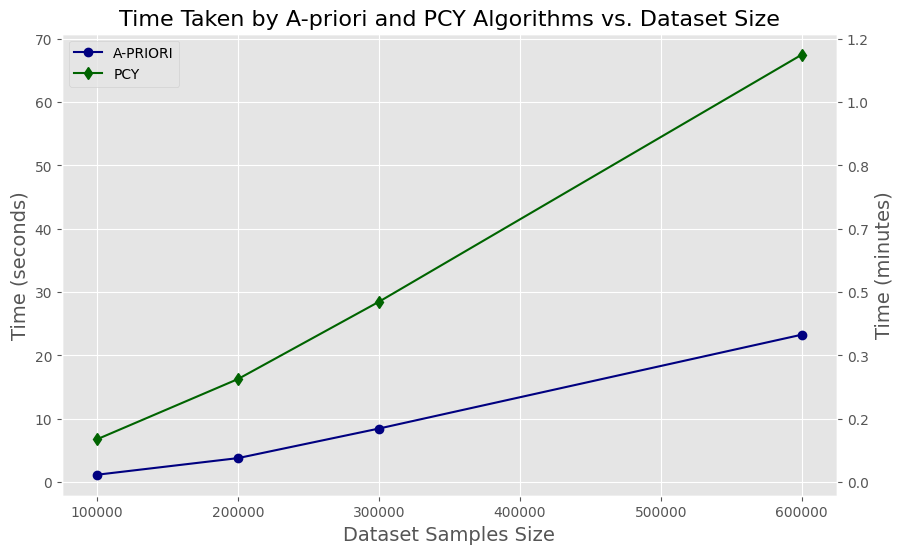

time: 489 ms (started: 2024-09-03 14:41:55 +00:00)


In [54]:
# Plot the time taken by the algorithms
def plot_results(samples: list[int], apriori_times: list[float], pcy_times: list[float]) -> None:
  """
  Plots the results.

  Args:
    samples: list of sample sizes.
    apriori_times: time taken by the A-priori algorithm.
    pcy_times: time taken by the PCY algorithm.

  Returns: None
  """
  fig, ax1 = plt.subplots(figsize=(10, 6))
  plt.style.use("ggplot")

  # Plotting results for A-priori algorithm
  ax1.plot(samples, apriori_times, marker="o", color="navy", label="A-PRIORI")

  # Plotting results for PCY algorithm
  ax1.plot(samples, pcy_times, marker="d", color="darkgreen", label="PCY")

  ax1.set_xlabel("Dataset Samples Size", fontsize=14)
  ax1.set_ylabel("Time (seconds)", fontsize=14)
  ax1.tick_params(axis="y")

  # Secondary y-axis for minutes
  ax2 = ax1.twinx()
  ax2.set_ylabel("Time (minutes)", fontsize=14)
  ax2.tick_params(axis="y")
  ax2.set_yticks(ax1.get_yticks())
  ax2.set_ylim(ax1.get_ylim())
  ax2.set_yticklabels([f"{i/60:.1f}" for i in ax1.get_yticks()])

  plt.title("Time Taken by A-priori and PCY Algorithms vs. Dataset Size", fontdict={"fontsize": 16})
  ax1.legend(loc="best")

  plt.rc("axes", axisbelow=True)
  plt.grid()

  plt.show()


# Plot Results
plot_results(samples=SAMPLE_LIST, apriori_times=apriori_times, pcy_times=pcy_times)
